In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
from optuna.samplers import TPESampler

from sklearn.decomposition import KernelPCA, PCA
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import Isomap, TSNE
from sklearn.covariance import EllipticEnvelope

from scipy.stats import pointbiserialr

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
train = pd.read_csv("/content/drive/MyDrive/dacon/신용카드 사기 거래 탐지/train.csv")
val = pd.read_csv("/content/drive/MyDrive/dacon/신용카드 사기 거래 탐지/val.csv")
test = pd.read_csv("/content/drive/MyDrive/dacon/신용카드 사기 거래 탐지/test.csv")

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113842 entries, 0 to 113841
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      113842 non-null  int64  
 1   V1      113842 non-null  float64
 2   V2      113842 non-null  float64
 3   V3      113842 non-null  float64
 4   V4      113842 non-null  float64
 5   V5      113842 non-null  float64
 6   V6      113842 non-null  float64
 7   V7      113842 non-null  float64
 8   V8      113842 non-null  float64
 9   V9      113842 non-null  float64
 10  V10     113842 non-null  float64
 11  V11     113842 non-null  float64
 12  V12     113842 non-null  float64
 13  V13     113842 non-null  float64
 14  V14     113842 non-null  float64
 15  V15     113842 non-null  float64
 16  V16     113842 non-null  float64
 17  V17     113842 non-null  float64
 18  V18     113842 non-null  float64
 19  V19     113842 non-null  float64
 20  V20     113842 non-null  float64
 21  V21     11

In [4]:
train.head(1)

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,3,-1.358354,-1.340163,1.773209,0.37978,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,-0.994972


In [5]:
val.head(1)

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
0,10,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.633753,-0.120794,-0.38505,-0.069733,0.094199,0.246219,0.083076,-0.255991,-0.994878,0


In [6]:
class_count = val[["ID", "Class"]].groupby("Class").count()
class_count['rate'] = class_count['ID'] / class_count['ID'].sum(axis=0)
class_count
# rate
# 0 : 0.998946
# 1 : 0.001054

,ID,rate
Class,,
0,28432,0.998946
1,30,0.001054


In [7]:
estimated_outlier = len(train) * class_count['rate'].values[1]
estimated_inlier = len(train) * class_count['rate'].values[0]
print("estimated_outlier :", estimated_outlier)
print("estimated_inlier :", estimated_inlier)

estimated_outlier : 119.99367577823062
estimated_inlier : 113722.00632422177


### Val set 기반으로 feature - class간 correlation 분석 (by Point Biserial Correlation) 

In [8]:
df = pd.DataFrame(index=val.drop(columns=['ID', "Class"], axis=1).columns, 
                  columns=['correlation', 'P-value', 'significant'], 
                  dtype=np.float64)

for idx in df.index:
  pbc = pointbiserialr(val['Class'], val[idx])
  df.loc[idx, 'correlation'] = pbc.correlation
  df.loc[idx, 'P-value'] = pbc.pvalue
  df.loc[idx, 'significant'] = True if pbc.pvalue < 0.05 else False
df[(abs(df['correlation'])<0.2) & (df['significant'] == True)]

,correlation,P-value,significant
V1,-0.109284,2.416760e-76,True
V2,0.096823,3.010169e-60,True
V4,0.126146,2.761228e-101,True
V5,-0.112254,1.795328e-80,True
V6,-0.045676,1.263197e-14,True
V8,0.038359,9.576917e-11,True
V9,-0.098666,1.665406e-62,True
V11,0.142082,3.076620e-128,True
V16,-0.169542,1.590710e-182,True
V18,-0.096104,2.220362e-59,True


In [9]:
drop_list = df[(abs(df['correlation'])<0.2) & (df['significant'] == True)].index.tolist()
drop_list.extend(df[df['significant'] == False].index.tolist())
print("Drop List -> ", drop_list)
print("Remain List ->", [val for val in train.columns.tolist() if val not in drop_list ])
print("length of Drop list :", len(drop_list))

Drop List ->  ['V1', 'V2', 'V4', 'V5', 'V6', 'V8', 'V9', 'V11', 'V16', 'V18', 'V19', 'V20', 'V22', 'V27', 'V28', 'V13', 'V15', 'V21', 'V23', 'V24', 'V25', 'V26', 'V29', 'V30']
Remain List -> ['ID', 'V3', 'V7', 'V10', 'V12', 'V14', 'V17']
length of Drop list : 24


### Preprocessing => drop + scaling


In [10]:
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train.drop(columns=drop_list+["ID"], axis=1))
scaled_val = scaler.transform(val.drop(columns=drop_list+["Class", "ID"], axis=1))
scaled_test = scaler.transform(test.drop(columns=drop_list + ["ID"], axis=1))

### Kernel PCA
- 실행하니까 RAM 부족으로 세션 다운됨..
- valid set도 RAM 부족으로 세션 다운

In [15]:
pca = PCA(n_components=2)
transformed_X = pca.fit_transform(scaled_val)
print(transformed_X.shape)

(28462, 2)


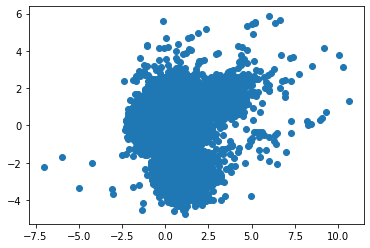

In [16]:
plt.scatter(transformed_X[:, 0], transformed_X[:, 1])
plt.show()

### Isomap
- 왜 이렇게 오래 걸리는 지 모르겠음..

In [ ]:
'''
embedding = Isomap(n_components=4)
x_embed = embedding.fit_transform(scaled_val)
'''

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


### TSNE로 시각화
- 실패..

In [13]:
tsne = TSNE(n_components=2, perplexity=50, n_jobs=-1, learning_rate=100)
tsne_embed = tsne.fit_transform(scaled_val)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


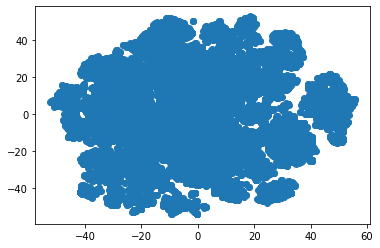

In [14]:
plt.scatter(tsne_embed[:, 0], tsne_embed[:, 1])
plt.show()

### performance record
1. GM
- n_com=5, n_init=5, seed=42 (no-drop) =====> 0.72
- n_com=5, n_init=5, seed=42 (drop) =====> 0.742
- n_com=10, n_init=5, seed=42 (drop) =====> 0.68
- n_com=7, n_init=5, seed=42 (drop) =====> 0.749
- n_com=6, n_init=6, seed=42 (drop) =====> 0.774 ---> drop threshold = 0.1
- n_com=6, n_init=6, seed=42 (drop) =====> 0.792 ---> drop threshold = 0.2
- n_com=6, n_init=6, seed=42 (drop) =====> 0.826 ---> drop 24 cols

### Gaussian Mixture Model

In [14]:
gmm = GaussianMixture(n_components=3, n_init=8, random_state=42, max_iter=300, init_params="random")

In [15]:
gmm.fit(scaled_train)

GaussianMixture(init_params='random', max_iter=300, n_components=3, n_init=8,
                random_state=42)

In [ ]:
'''
print(gmm.score(edit_val[edit_val['Class'] == 0].drop('Class', axis=1).values))
print(gmm.score(edit_val[edit_val['Class'] == 1].drop('Class', axis=1).values))
'''

"\nprint(gmm.score(edit_val[edit_val['Class'] == 0].drop('Class', axis=1).values))\nprint(gmm.score(edit_val[edit_val['Class'] == 1].drop('Class', axis=1).values))\n"

In [16]:
# Find best threshold

thresholds = np.linspace(-100, 0, 200)
y_scores = gmm.score_samples(scaled_val)
scores = []
for treshold in thresholds:
    y_hat = (y_scores < treshold).astype(int)
    scores.append(f1_score(y_pred=y_hat, y_true=val['Class'].values, average='macro'))

scores = np.array(scores)
print("score :", scores.max(), "thres:", thresholds[scores.argmax()])

score : 0.8394731804484362 thres: -31.155778894472363


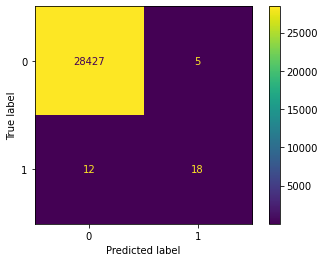

In [35]:
# confusion matrix
y_hat = (y_scores < thresholds[scores.argmax()]).astype(int)
y_true = val['Class'].values
matrix = confusion_matrix(y_true, y_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()
plt.show()

In [45]:
## Classification report
print(classification_report(y_true, y_hat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.78      0.60      0.68        30

    accuracy                           1.00     28462
   macro avg       0.89      0.80      0.84     28462
weighted avg       1.00      1.00      1.00     28462



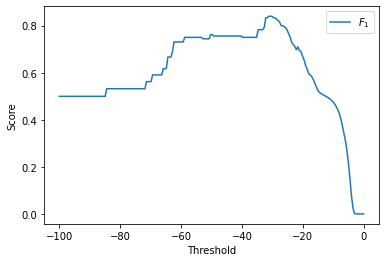

In [17]:
plt.plot(thresholds, scores, label='$F_1$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

In [ ]:
## Submission for GMM

thres = thresholds[scores.argmax()]
scores = gmm.score_samples(scaled_test)
pred = (scores < thres).astype(int)
sub = pd.DataFrame(index=test["ID"], columns=["ID", "Class"])
sub['ID'] = sub.index
sub['Class'] = pred
sub.to_csv("submisson.csv", index=False, header=True)

In [95]:
# +a로 Bayesian GMM
b_gmm = BayesianGaussianMixture(n_components=5, random_state=1, max_iter=300)
b_gmm.fit(scaled_train)

BayesianGaussianMixture(max_iter=300, n_components=5, random_state=1)

In [96]:
b_thresholds = np.linspace(-100, 0, 200)
b_y_scores = b_gmm.score_samples(scaled_val)
b_scores = []
for b_treshold in b_thresholds:
    y_hat = (b_y_scores < b_treshold).astype(int)
    b_scores.append(f1_score(y_pred=y_hat, y_true=val['Class'].values, average='macro'))

b_scores = np.array(b_scores)
print("score :", b_scores.max(), "thres:", b_thresholds[b_scores.argmax()])

score : 0.8398593381861659 thres: -30.150753768844226


## Unsupervised KNN

#### performance record
- n_neighbors = 15, drop 24 cols, thres = 4.37 => 0.81


### optuna
- NN이 inference에 너무 오래걸려서 튜닝 포기

In [39]:
sampler = TPESampler(seed=1)

def objective(trial):    
    params = {
        'n_neighbors':trial.suggest_int("n_neighbors", 5, 50),
        'metric': trial.suggest_categorical('metric', ['minkowski']),
        'algorithm': trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
        'leaf_size':trial.suggest_int("leaf_size", 30, 60),
        'radius':trial.suggest_float('radius', 1, 3),
        'p': trial.suggest_categorical('p', [1, 2]),
        'n_jobs': -1,
    }
    
    model = NearestNeighbors(**params)
    model.fit(scaled_train)
    distances, indexes = model.kneighbors(scaled_train)
    thres = sorted(distances.mean(axis=1))[-120]

    dist, idx = model.kneighbors(scaled_val)
    temp = pd.DataFrame(data=np.mean(dist, axis=1), index=val.index)
    temp['label'] = temp[0].apply(lambda x: 1 if x >= thres else 0)

    return f1_score(val['Class'], temp['label'], average="macro")


In [40]:
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

best_model = study.best_trial
best_params = best_model.params

print("Best model:")
print("  F1-score: {}".format(round(best_model.value, 4)))
print("  params  : {}".format(best_params))

[I 2022-11-17 04:10:59,008] A new study created in memory with name: no-name-084465c1-2537-4d66-beb1-d773d0c45715
[I 2022-11-17 04:11:10,624] Trial 0 finished with value: 0.7997889701744514 and parameters: {'n_neighbors': 24, 'metric': 'minkowski', 'algorithm': 'auto', 'leaf_size': 32, 'radius': 1.3725204227553418, 'p': 2}. Best is trial 0 with value: 0.7997889701744514.
[I 2022-11-17 04:20:01,686] Trial 1 finished with value: 0.8212527256101849 and parameters: {'n_neighbors': 29, 'metric': 'minkowski', 'algorithm': 'brute', 'leaf_size': 30, 'radius': 2.3409350203568042, 'p': 2}. Best is trial 1 with value: 0.8212527256101849.
[I 2022-11-17 04:20:20,117] Trial 2 finished with value: 0.8228746683766996 and parameters: {'n_neighbors': 11, 'metric': 'minkowski', 'algorithm': 'kd_tree', 'leaf_size': 51, 'radius': 2.7527783045920766, 'p': 1}. Best is trial 2 with value: 0.8228746683766996.
[I 2022-11-17 04:23:48,674] Trial 3 finished with value: 0.7797097574275713 and parameters: {'n_neighb

KeyboardInterrupt: ignored

In [ ]:
{'n_neighbors': 36, 'metric': 'minkowski', 'algorithm': 'brute', 'leaf_size': 53, 'radius': 1.5608879841288104, 'p': 1}

In [65]:
neigh = NearestNeighbors(n_neighbors=30, metric='minkowski', algorithm='auto', leaf_size=50, radius=1.5, p=2, n_jobs=-1)

In [66]:
# fit
neigh.fit(scaled_train)

NearestNeighbors(leaf_size=50, n_jobs=-1, n_neighbors=30, radius=1.5)

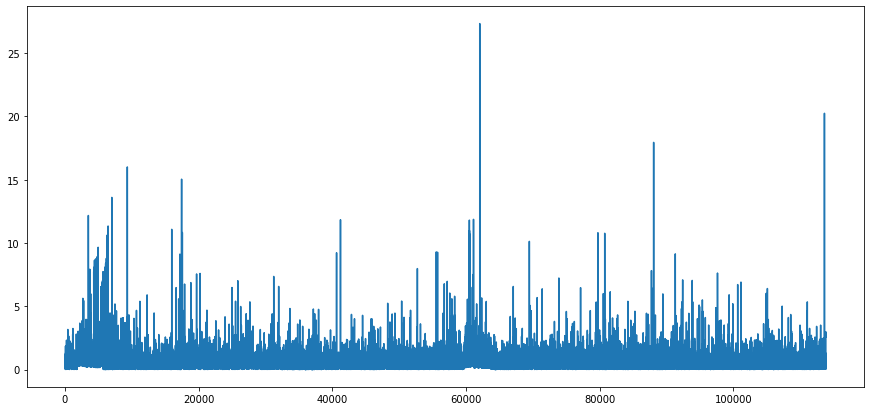

In [67]:
# distances and indexes of k-neaighbors from model outputs
distances, indexes = neigh.kneighbors(scaled_train)
# plot
plt.figure(figsize=(15, 7))
plt.plot(distances.mean(axis =1))

In [68]:
distances = pd.DataFrame(distances)
distances_mean = distances.mean(axis =1)
distances_mean.sort_values(axis='index')[-120:]
# mean 기준은 16로 고정

94871      5.089930
2780       5.170089
7476       5.175335
61586      5.182091
99906      5.194286
            ...    
17446     15.031529
9324      15.996514
88069     17.936906
113622    20.235482
62051     27.321360
Length: 120, dtype: float64

In [69]:
_li = sorted(distances_mean.sort_values(axis='index').values)

In [70]:
dist, idx = neigh.kneighbors(scaled_val)

In [71]:
temp = pd.DataFrame(data=np.mean(dist, axis=1), index=val.index)
scores = []
for i in range(80, 250):
  thres = _li[-i]
  temp['label'] = temp[0].apply(lambda x: 1 if x > thres else 0)
  scores.append(f1_score(val['Class'], temp['label'], average="macro"))
print(max(scores))

0.833183877528294


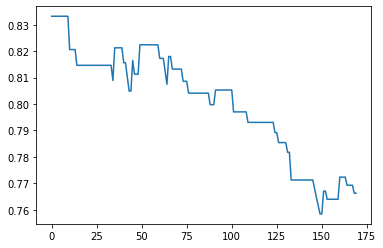

In [72]:
plt.plot(scores)
plt.show()

## Isolation Forest (No Local Outlier Factor!)

In [77]:
forest = IsolationForest(contamination=class_count['rate'].values[1], random_state=1)
forest.fit(scaled_train)
pred = forest.predict(scaled_val)
pred = np.where(pred == 1, 0, 1)

In [78]:
f1_score(val['Class'].values, pred,average="macro")

0.7756334613616767

### EllipticEnvelope

In [80]:
cov = EllipticEnvelope(support_fraction = 0.994, contamination = class_count['rate'].values[1], random_state = 42)
cov.fit(train.drop("ID", axis=1))

EllipticEnvelope(contamination=0.0010540369615627855, random_state=42,
                 support_fraction=0.994)

In [81]:
pred = cov.predict(val.drop(columns=["ID", "Class"], axis=1))
pred = np.where(pred == 1, 0, 1)
f1_score(val['Class'].values, pred,average="macro")

0.8927516353661109

In [82]:
print(classification_report(val['Class'].values, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.85      0.73      0.79        30

    accuracy                           1.00     28462
   macro avg       0.92      0.87      0.89     28462
weighted avg       1.00      1.00      1.00     28462

